自注意力则因为并⾏计算而放弃了顺序操作.为了使用序列的顺序信息,通过在输⼊表示中添加位置编码(positional encoding)来注⼊绝对的或相对的位置信息.
位置编码可以通过学习得到也可以直接固定得到.下面描述的是基于正弦函数和余弦函数的固定位置编码.

假设输入$ X \in \mathbb{R}^{n \times d} $包含一个序列中$n$个词元的$d$维嵌入表示.
位置编码使用相同形状的位置矩阵$P \in \mathbb{R}^{n \times d}$输出$X + P$,矩阵$P$第$i$行、第$2j$列和$2j+1$列上的元素为:

\begin{aligned}
P_{i, 2 j} &=\sin \left(\frac{i}{10000^{2 j / d}}\right) \\
P_{i, 2 j+1} &=\cos \left(\frac{i}{10000^{2 j / d}}\right)
\end{aligned}

除了捕获绝对位置信息之外,上述的位置编码还允许模型学习得到输⼊序列中相对位置信息.
这是因为对于任何确定的位置偏移$\delta$,位置$i + \delta$处的位置编码可以线性投影位置$ i $处的位置编码来表示.

令$ \omega_{j}=1 / 10000^{2 j / d} $,投影矩阵$A=\left[\begin{array}{cc}
\cos \left(\delta \omega_{j}\right) & \sin \left(\delta \omega_{j}\right) \\
-\sin \left(\delta \omega_{j}\right) & \cos \left(\delta \omega_{j}\right)
\end{array}\right]$

\begin{aligned}
& {\left[\begin{array}{cc}
\cos \left(\delta \omega_{j}\right) & \sin \left(\delta \omega_{j}\right) \\
-\sin \left(\delta \omega_{j}\right) & \cos \left(\delta \omega_{j}\right)
\end{array}\right]
\left[\begin{array}{c}
P_{i, 2 j} \\
P_{i, 2 j+1}
\end{array}\right] } \\\
=& {\left[\begin{array}{cc}
\cos \left(\delta \omega_{j}\right) & \sin \left(\delta \omega_{j}\right) \\
-\sin \left(\delta \omega_{j}\right) & \cos \left(\delta \omega_{j}\right)
\end{array}\right]
\left[\begin{array}{c}
\sin \left(i \omega_{j}\right) \\
\cos \left(i \omega_{j}\right)
\end{array}\right] } \\\
=& {\left[\begin{array}{c}
\cos \left(\delta \omega_{j}\right) \sin \left(i \omega_{j}\right)+\sin \left(\delta \omega_{j}\right) \cos \left(i \omega_{j}\right) \\
-\sin \left(\delta \omega_{j}\right) \sin \left(i \omega_{j}\right)+\cos \left(\delta \omega_{j}\right) \cos \left(i \omega_{j}\right)
\end{array}\right] } \\\
=& {\left[\begin{array}{l}
\sin \left((i+\delta) \omega_{j}\right) \\
\cos \left((i+\delta) \omega_{j}\right)
\end{array}\right] } \\\
=& {\left[\begin{array}{c}
P_{i+\delta, 2 j} \\
P_{i+\delta, 2 j+1}
\end{array}\right]}
\end{aligned}

由上可知,$ 2 \times 2 $投影矩阵$A$不依赖于任何位置的索引$i$.

In [59]:
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import seaborn as sns


class PositionalEncoding(nn.Module):
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout)
        # 创建⼀个足够长的P
        self.P = torch.zeros((1, max_len, num_hiddens))
        X = torch.arange(max_len, dtype=torch.float32).reshape(-1, 1) / torch.pow(10000, torch.arange(0, num_hiddens, 2,
                                                                                                      dtype=torch.float32) / num_hiddens)
        self.P[:, :, 0::2] = torch.sin(X)
        self.P[:, :, 1::2] = torch.cos(X)

    def forward(self, X):
        X = X + self.P[:, :X.shape[1], :].to(X.device)
        return self.dropout(X)

In [60]:
encoding_dim, num_steps = 32, 60
pos_encoding = PositionalEncoding(encoding_dim, 0)
pos_encoding.eval()
X = pos_encoding(torch.zeros((1, num_steps, encoding_dim)))
pos_encoding.P.shape

torch.Size([1, 1000, 32])

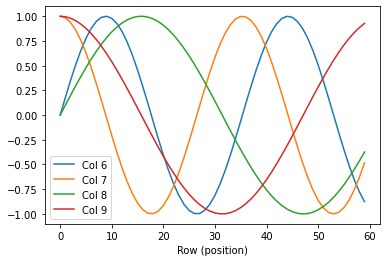

In [61]:
P = pos_encoding.P[:, :X.shape[1], :]
plt.plot(torch.arange(num_steps), P[0, :, 6], label='Col 6')
plt.plot(torch.arange(num_steps), P[0, :, 7], label='Col 7')  # 平移
plt.plot(torch.arange(num_steps), P[0, :, 8], label='Col 8')  # 周期改变
plt.plot(torch.arange(num_steps), P[0, :, 9], label='Col 9')
plt.xlabel('Row (position)')
plt.legend()
plt.show()

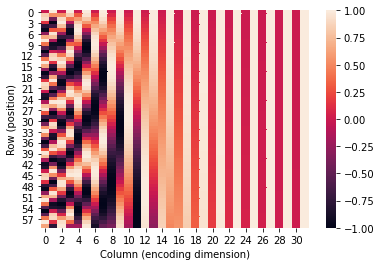

In [62]:
P_heat = torch.squeeze(pos_encoding.P[:, :X.shape[1], :])

fig = plt.figure()
ax = plt.subplot(111)
# 位置编码矩阵热力图
h1 = sns.heatmap(P_heat, ax=ax)
ax.set_xlabel("Column (encoding dimension)")
ax.set_ylabel("Row (position)")
plt.show()